## Task 3.1 Convergence and attractors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Initialize some data from lab instructions

In [5]:
x1=np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2=np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3=np.array([-1, 1, 1, -1, -1, 1, -1, 1])

x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1,])

#### Synchronous Hopfield - note, all data is in row format

In [28]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp):
        recall_prev = np.copy(dp)
        recall = self.hop_sign(np.matmul(np.copy(dp), self.W))
        while not np.array_equal(recall, recall_prev):
            recall_prev = np.copy(recall)
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

#### Some test funcs to see if recall recalls properly

In [29]:
def test_recall_sync(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_sync(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled)))

def test_recall_seq(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled = test_net.recall_seq(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled))) 

##### Some sanity checks

In [30]:
data = np.vstack((x1, x2, x3))
test_recall_sync(data, data)
test_recall_seq(data, data)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


###  Actual 3.1

#### Check convergence of distorted data points

In [6]:
data = np.vstack((x1, x2, x3))
data_dist = np.vstack((x1d, x2d, x3d))
test_recall_sync(data, data_dist)
test_recall_seq(data, data_dist)

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True
x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True


#### Check for all attractors

In [7]:
# Please change this if you get a better idea than to brute force it with all possible input vectors
def dp_builder(dim):
    vec = np.zeros(dim)
    return dp_builder_h(dim, vec, 0)
def dp_builder_h(dim, curr_vec, curr_ind):
    # Need to copy so vec2 does not mess this up later
    vec1 = np.copy(curr_vec)
    vec1[curr_ind] = 1
    # Don't need to copy since no one else will use curr_vec
    vec2 = curr_vec
    vec2[curr_ind] = -1
    # Base case, reached last index of vector
    if dim == curr_ind + 1:
        return np.vstack((vec1, vec2))
    else:
        return np.vstack((
            dp_builder_h(dim, vec1, curr_ind + 1),
            dp_builder_h(dim, vec2, curr_ind + 1)
        ))        

In [8]:
data = np.vstack((x1, x2, x3))
test_net = Hopfield_net(data)
all_dp = dp_builder(x1.shape[0])
attractors = np.zeros(all_dp.shape)

# Brute force it - recall for every possible input vector
for i in range(all_dp.shape[0]):
    attractors[i] = test_net.recall_sync(all_dp[i])

# Remove duplicates
attractors = np.unique(attractors, axis=0)
print(attractors)
print("In total {} attractors".format(attractors.shape[0]))
    

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
In total 14 attractors


#### Testing even more distorted patterns

In [9]:
# Flip first 5 
x1_superd=np.copy(x1)
for i in range(x1.size // 2 + 1):
    x1_superd[i] = x1_superd[i] * -1

test_recall_sync(x1.reshape((1, -1)), x1_superd.reshape((1, -1)), test_net)
    

x1 recalled properly: False
	orig: [-1 -1  1 -1  1 -1 -1  1]
	dist: [ 1  1 -1  1 -1 -1 -1  1]
	recl: [ 1  1  1  1  1 -1  1  1]


## 3.2 Sequential Update

#### Load the data

In [ ]:
file_path_pic_data = 'datasets/pict.dat'

num_pics = 11
num_attrs = 1024

# Open file and read in the array from string to int
raw_data = []
with open(file_path_pic_data, 'r') as file:
    for line in file:
        raw_data = list(map(int, line.split(',')))
        # It should only be a single line but just in case
        break
pic_data = np.array(raw_data).reshape(num_pics, num_attrs)

# Sanity check that we did the reshaping right
for i in range(num_pics):
    for j in range(num_attrs):
        if raw_data[num_attrs*i + j] != pic_data[i, j]:
            print("Error, reshape incorrect!")

pic_data_dist = pic_data[9:]
pic_data = pic_data[:9] # pattern p10 is a degraded version of p1 and p11 is a degraded version of p2 and p3

(11, 1024)


In [7]:
pic_data.shape

(9, 1024)

In [23]:
print(data)
print(data[:3])

[[-1 -1  1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]]
[[-1 -1  1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]]


#### Define function for drawing the pictures

In [8]:
import matplotlib.pyplot as plt

def show_image_from_vec(dp, title=None):
    im_data = dp.reshape(32, 32)
    plt.imshow(im_data)
    if title is not None:
        plt.title(title)
    plt.show()

#### Train with 3 pictures

In [16]:
pic_data_3 = pic_data[:3]
test_recall_seq(pic_data_3, pic_data_3)

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True


#### With random recall the picture recalls properly - with non-random it lands in a spurious attractor

Recalled x1: False


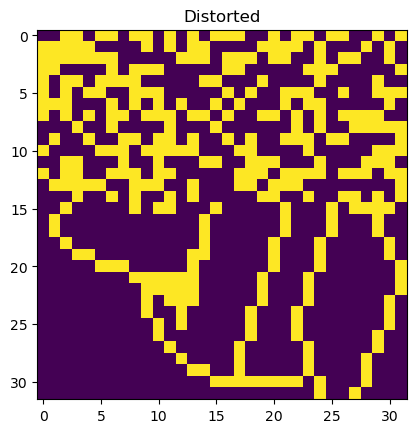

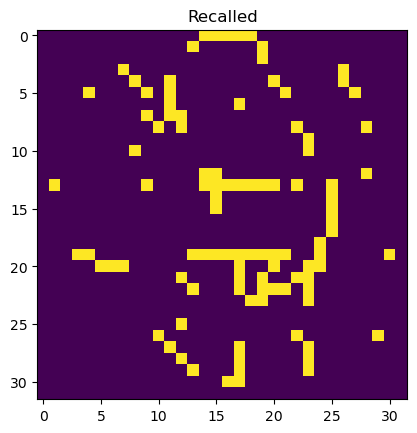

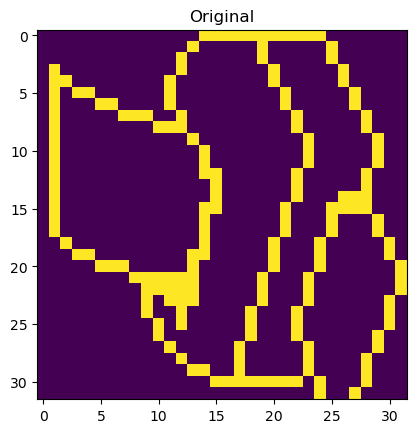

In [ ]:
pic_net = Hopfield_net(pic_data_3)
#test_recall_seq(pic_data_3[0].reshape((1, -1)), pic_data_dist[0].reshape((1, -1)), printout=False, test_net=pic_net)
did_recall_x1 = np.array_equal(pic_data_3[0], pic_net.recall_seq(pic_data_dist[0]))
print("Recalled x1: {}".format(did_recall_x1))
show_image_from_vec(pic_data_dist[0], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[0]), title="Recalled")
show_image_from_vec(pic_data_3[0], title="Original")


### Check the other distorted pic

Recalled x2: True
Recalled x3: False


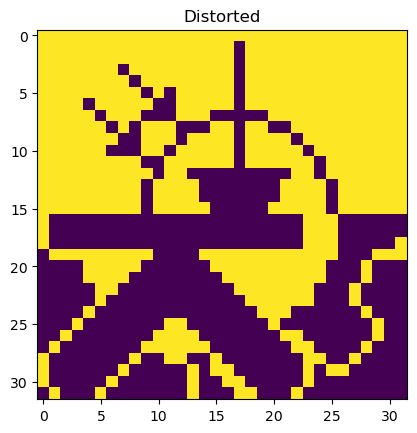

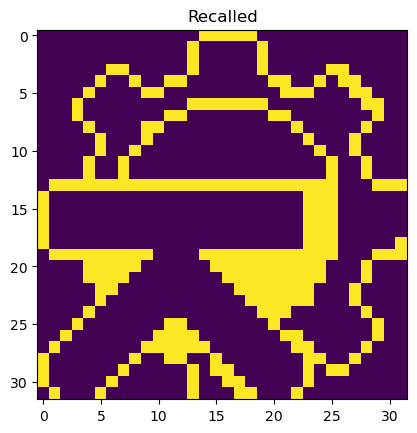

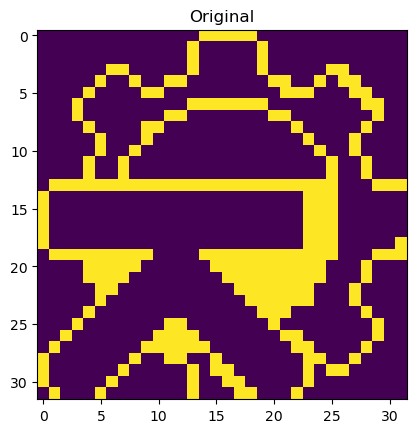

In [21]:
#pic_dist = np.vstack((pic_data_dist[1], pic_data_dist[1])).reshape((2, -1))
#test_recall_seq(pic_data_3[1:2].reshape((2, -1)), pic_dist, printout=False, test_net=pic_net)

did_recall_x2 = np.array_equal(pic_data_3[1], pic_net.recall_seq(pic_data_dist[1]))
did_recall_x3 = np.array_equal(pic_data_3[2], pic_net.recall_seq(pic_data_dist[1]))
print("Recalled x2: {}".format(did_recall_x2))
print("Recalled x3: {}".format(did_recall_x3))
show_image_from_vec(pic_data_dist[1], title="Distorted")
show_image_from_vec(pic_net.recall_seq(pic_data_dist[1]), title="Recalled")
show_image_from_vec(pic_data_3[1], title="Original")

### Make a new Hopfield net since they want us to print during recall - less messy (but still messy)

In [ ]:
class Hopfield_net_pics(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        self.it = 0
        
    # Overwrite to print pictures
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            if self.it % 100 == 0:
                show_image_from_vec(ret, title="Recall after {} iterations".format(self.it))
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            self.it += 1
        return ret

### With random pic 0 gets spurious and pic 1 recalls 1 - without random vice versa

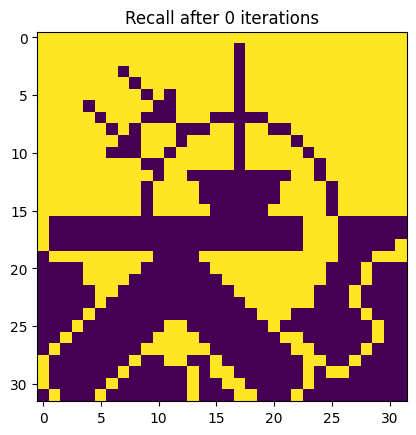

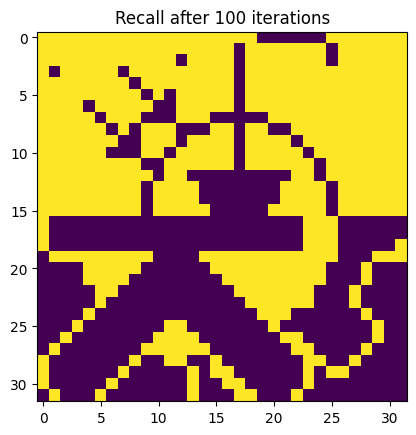

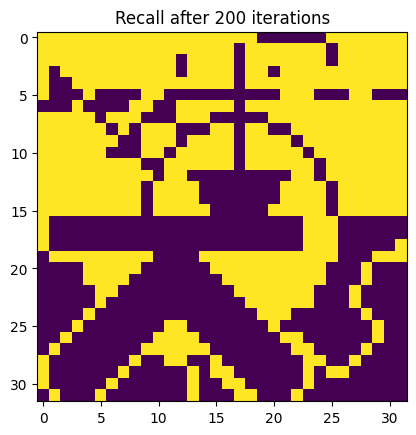

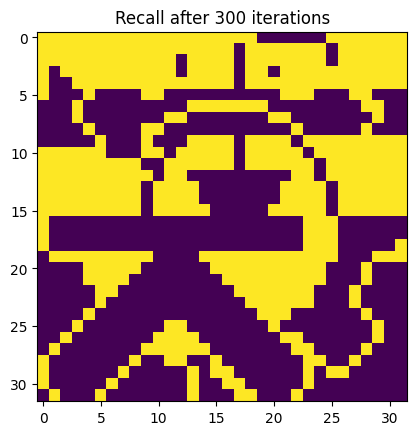

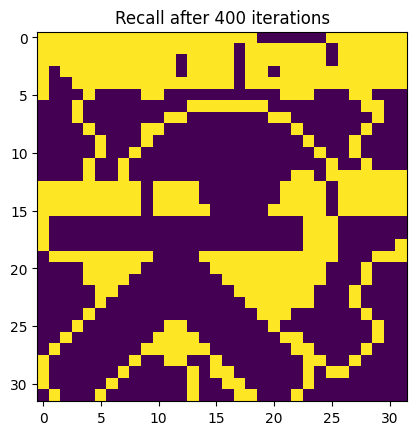

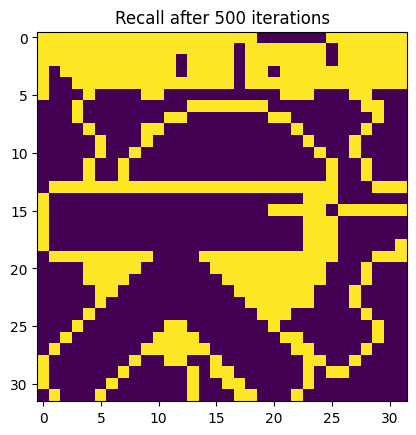

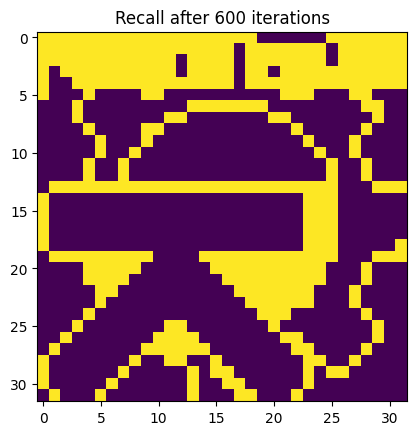

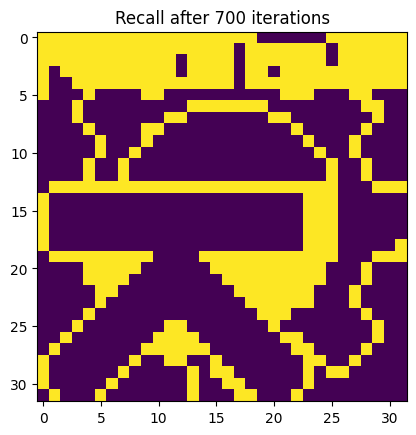

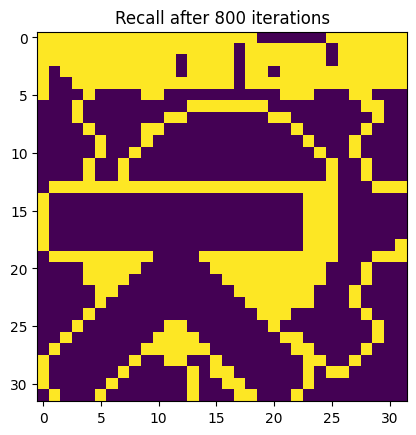

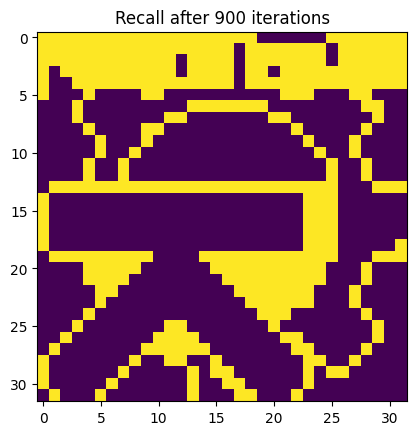

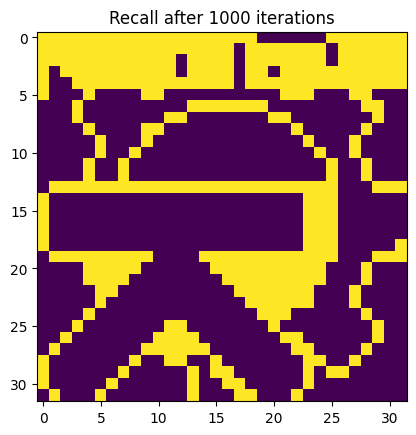

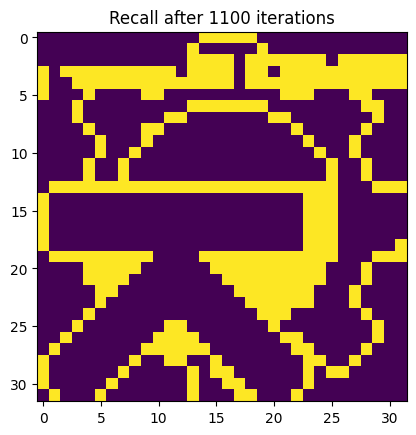

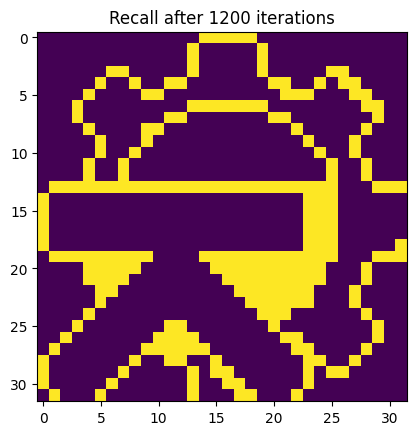

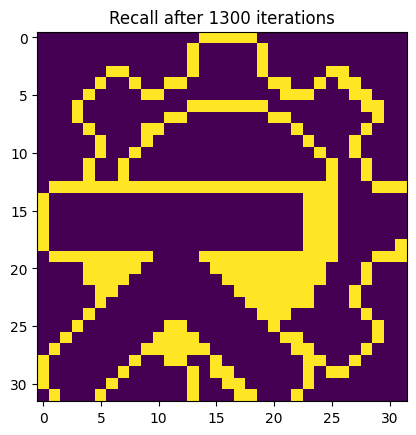

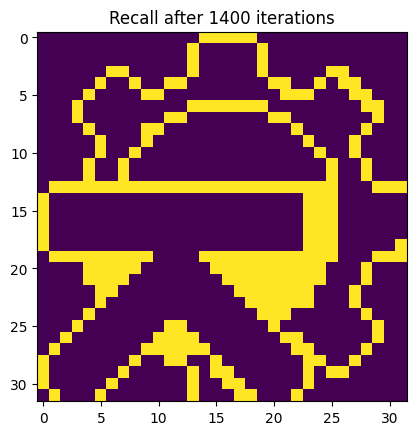

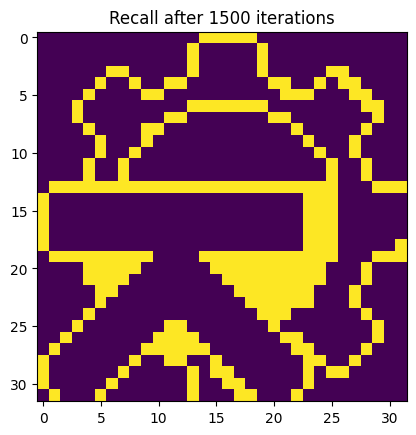

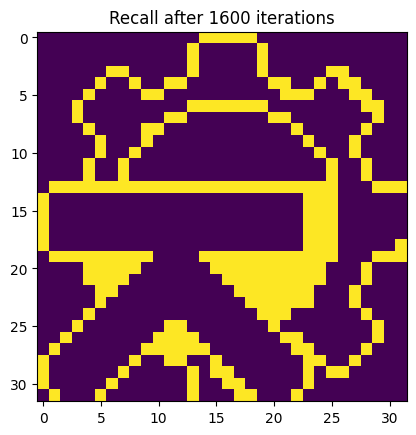

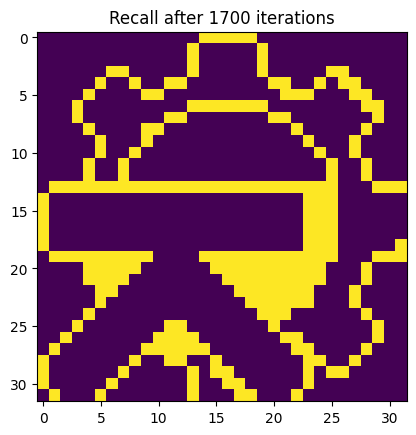

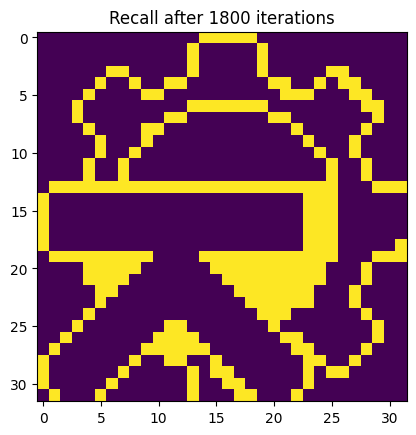

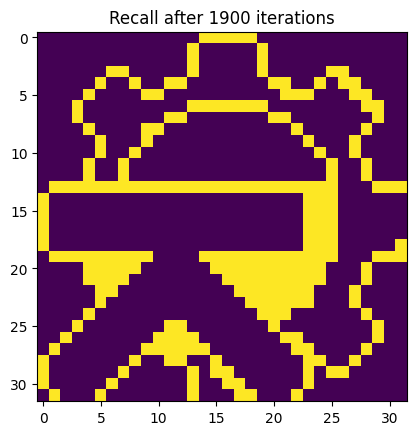

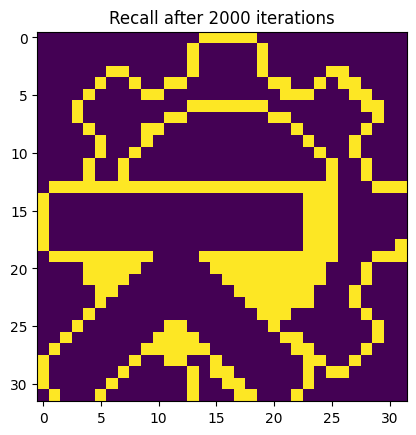

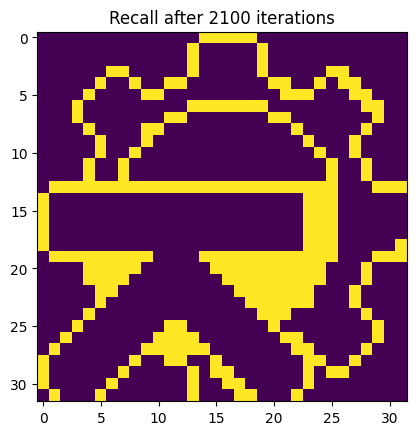

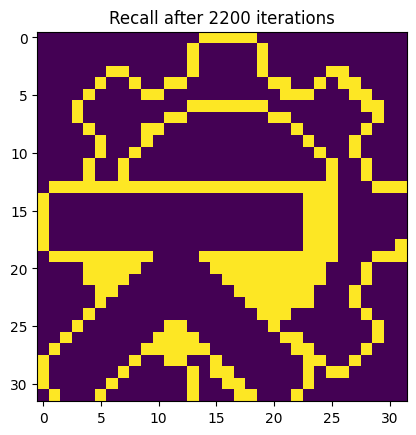

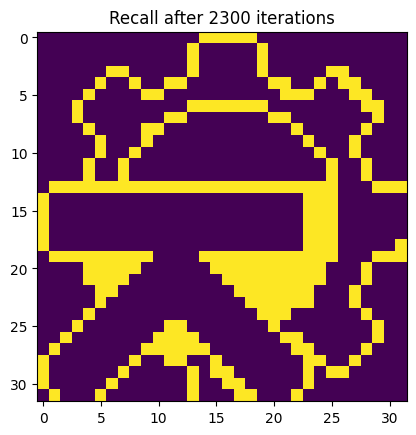

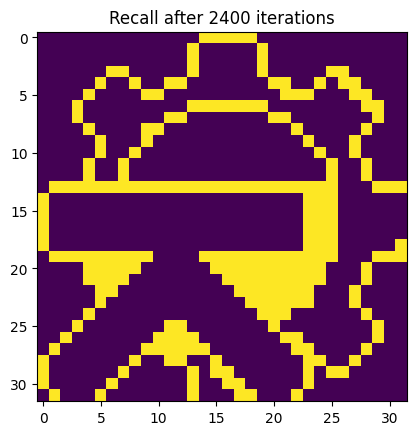

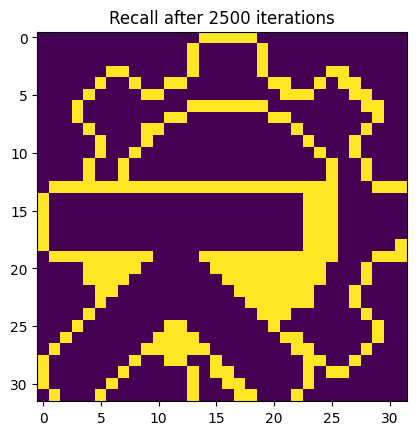

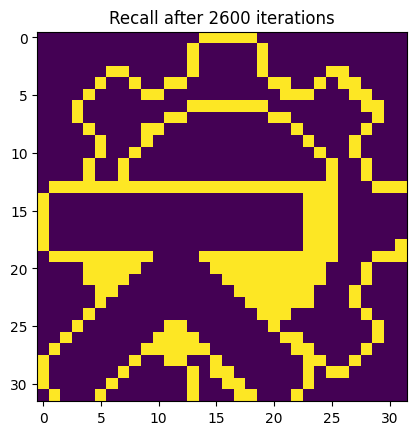

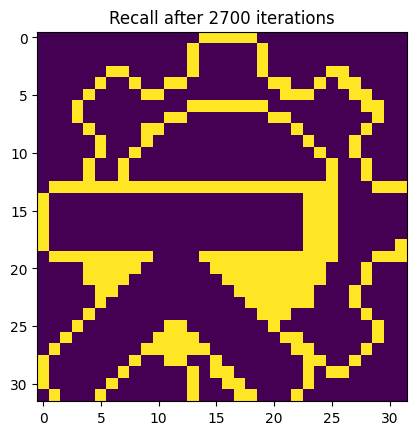

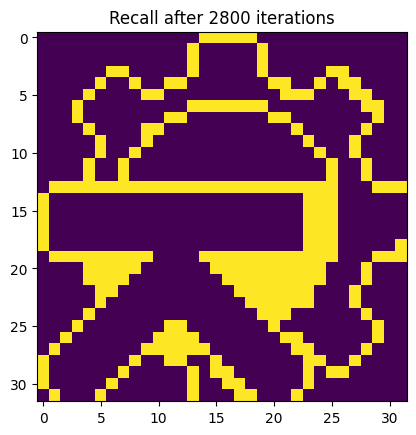

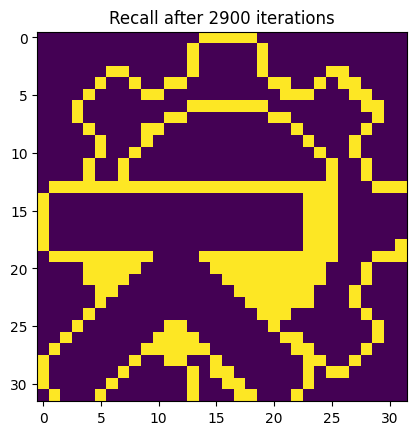

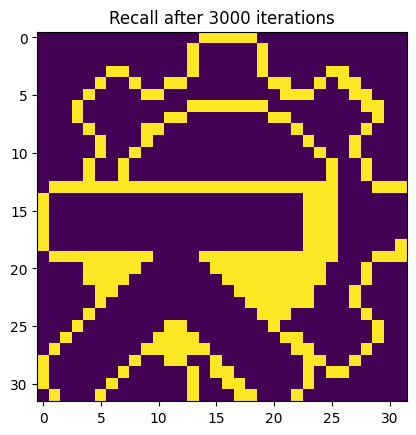

In [52]:
pic_net_printing = Hopfield_net_pics(pic_data_3)

printed_end = pic_net_printing.recall_seq(pic_data_dist[1])

## 3.3 Energy

In [103]:
# overwrite to include energy calculations
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

### What is the energy at different atractors?

In [104]:
data = np.vstack((x1, x2, x3))
test_net = Hopfield_net_energy(data)
all_dp = dp_builder(x1.shape[0])
attractors = np.zeros(all_dp.shape)

# Brute force it - recall for every possible input vector
for i in range(all_dp.shape[0]):
    attractors[i], _  = test_net.recall_seq(all_dp[i])

# Remove duplicates
attractors = np.unique(attractors, axis=0)
print(attractors)
print("In total {} attractors".format(attractors.shape[0]))
    

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
In total 14 attractors


In [105]:
for attractor in attractors: 
    energy = test_net.calculate_energy(attractor)
    print(f"The energy for attractor{attractor} is {energy}")


The energy for attractor[-1. -1. -1. -1. -1.  1. -1. -1.] is -68.0
The energy for attractor[-1. -1. -1. -1.  1. -1. -1. -1.] is -36.0
The energy for attractor[-1. -1.  1. -1. -1.  1. -1.  1.] is -68.0
The energy for attractor[-1. -1.  1. -1.  1. -1. -1.  1.] is -68.0
The energy for attractor[-1. -1.  1. -1.  1.  1. -1.  1.] is -56.0
The energy for attractor[-1.  1. -1. -1. -1.  1. -1. -1.] is -56.0
The energy for attractor[-1.  1.  1. -1. -1.  1. -1.  1.] is -72.0
The energy for attractor[-1.  1.  1. -1.  1. -1. -1.  1.] is -56.0
The energy for attractor[ 1. -1. -1.  1.  1. -1.  1. -1.] is -72.0
The energy for attractor[ 1.  1. -1.  1. -1.  1.  1. -1.] is -68.0
The energy for attractor[ 1.  1. -1.  1.  1. -1.  1. -1.] is -68.0
The energy for attractor[ 1.  1. -1.  1.  1.  1.  1. -1.] is -56.0
The energy for attractor[ 1.  1.  1.  1. -1.  1.  1.  1.] is -36.0
The energy for attractor[ 1.  1.  1.  1.  1. -1.  1.  1.] is -68.0


### What is the energy on at the points of the distorted patterns?

In [106]:
# patterns
x1=np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2=np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3=np.array([-1, 1, 1, -1, -1, 1, -1, 1])

x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1,])

In [107]:
def test_recall_seq(data, data_dist, test_net=None, printout=True):
    if test_net is None:
        test_net = Hopfield_net(data)
    for i in range(data.shape[0]):
        recalled, _  = test_net.recall_seq(data_dist[i])
        did_recall = np.array_equal(data[i], recalled)
        print("x{} recalled properly: {}".format(i + 1, did_recall))
        if not did_recall and printout:
            print("\torig: {}".format(np.array2string(data[i])))
            print("\tdist: {}".format(np.array2string(data_dist[i])))
            print("\trecl: {}".format(np.array2string(recalled)))


test_recall_seq(data=data, data_dist=data_dist, test_net=test_net)

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True


In [108]:
data = np.vstack((x1,x2,x3))
data_dist = np.vstack((x1d,x2d,x3d))

test_net = Hopfield_net_energy(data)


test_recall_seq(data=data, data_dist=data_dist, test_net=test_net)

for i, x in enumerate(data_dist):
    #print(x)
    energy = test_net.calculate_energy(x)
    print(f"The energy for the disorted patter of x{i+1} is {energy}")

x1 recalled properly: True
x2 recalled properly: False
	orig: [-1 -1 -1 -1 -1  1 -1 -1]
	dist: [ 1  1 -1 -1 -1  1 -1 -1]
	recl: [-1  1 -1 -1 -1  1 -1 -1]
x3 recalled properly: True
The energy for the disorted patter of x1 is -40.0
The energy for the disorted patter of x2 is -36.0
The energy for the disorted patter of x3 is -24.0


### What is the energy on at the points of the original patterns?

In [109]:
data = np.vstack((x1,x2,x3))
data_dist = np.vstack((x1d,x2d,x3d))

test_net = Hopfield_net_energy(data)


test_recall_seq(data=data, data_dist=data, test_net=test_net)

for i, x in enumerate(data):
    #print(x)
    energy = test_net.calculate_energy(x)
    print(f"The energy for the disorted patter of x{i+1} is {energy}")

x1 recalled properly: True
x2 recalled properly: True
x3 recalled properly: True
The energy for the disorted patter of x1 is -68.0
The energy for the disorted patter of x2 is -68.0
The energy for the disorted patter of x3 is -72.0


**Conparing this to the calculated energies of all attractors makes reasonable sense as these are the overall lowest energies, with an exception that there is one other attractor (not part of the training data) that also has energy -72.0.**

### Plot energy changes from interation to interaton when using sequential updates

[[np.float64(-425964.0), np.float64(-425964.0), np.float64(-430144.0), np.float64(-434348.0), np.float64(-434348.0), np.float64(-438576.0), np.float64(-442828.0), np.float64(-442828.0), np.float64(-447104.0), np.float64(-451404.0), np.float64(-451404.0), np.float64(-455728.0), np.float64(-455728.0), np.float64(-460076.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-461840.0), np.float64(-463628.0), np.float64(-463760.0), np.float64(-463760.0), np.float64(-463916.0), np.float64(-463916.0), np.float64(-463916.0), np.float64(-464096.0), np.float64(-468460.0), np.float64(-472848.0), np.float64(-472848.0), np.float64(-472848.0), np.float64(-477260.0), np.float64(-477260.0), np.float64(-481696.0), np.float64(-486156.0), np.float64(-490640.0), np.float64(-495148.0), np.float64(-499680.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-504236.0), np.float64(-508816.0), np.float64(-508816.0), np.float6

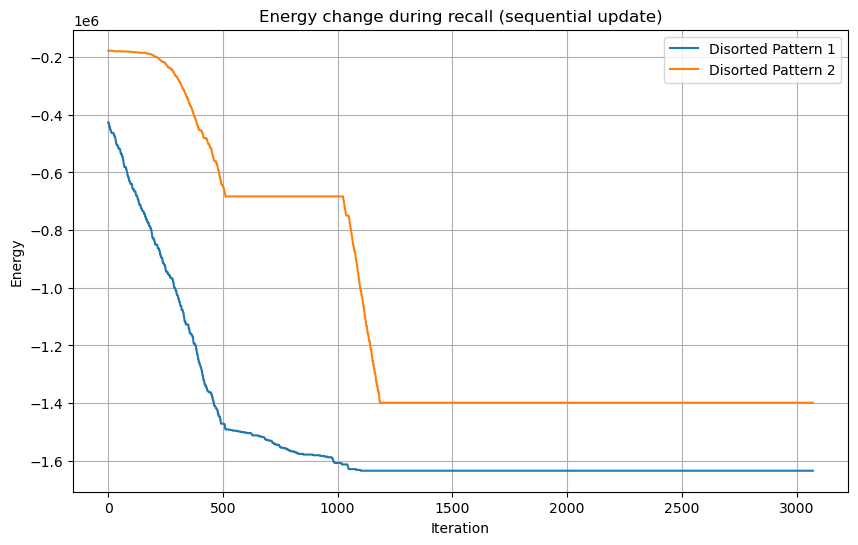

In [110]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# same class but with weights initialised normal 
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        np.random.seed(42)
        self.W= np.random.normal(loc=0, scale=1.0, size = (data.shape[1],data.shape[1])) # setting weights to normal distribution and diagonal weights to 0
        np.fill_diagonal(self.W,0)
        

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

In [121]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

**Observations**

- Never (5 mins tested) coverged/found a stable state.
- To be expexted as weights are asymmetric unless explicitly symmetrized (symmetry ensures the existance of an energy function that decreases or stays constant)

### Setting weigths matrix symetric

Notes Sebastian: Symmetry refers to the property of the connection (weight) matrix $ W $, where $ w_{ij} = w_{ji} $ for all neurons $ i $ and $ j $ (i.e., the matrix is equal to its transpose, $ W = W^T $). This means the strength of the connection from neuron $ j $ to $ i $ is identical to the connection from $ i $ to $ j $, creating bidirectional, reciprocal links between neurons.

In [125]:
# same class but with weights initialised normal ans symmetric weight matrix
class Hopfield_net_energy(Hopfield_net):
    def __init__(self, data, scale=False):
        super().__init__(data, scale=scale)
        np.random.seed(42)
        self.W= np.random.normal(loc=0, scale=1.0, size = (data.shape[1],data.shape[1])) # setting weights to normal distribution and diagonal weights to 0
        np.fill_diagonal(self.W,0)
        self.W = 0.5 * (self.W*np.transpose(self.W))
        

    def calculate_energy(self, X):

       return - np.sum(self.W * np.outer(X,X))
       
    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        energy_history = []

        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order, energy_history=energy_history)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order, energy_history=energy_history)

        return recall.astype(int), energy_history
    
     # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order, energy_history):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
            energy_history.append(self.calculate_energy(ret))
        return ret

[[np.float64(760.9483945876447), np.float64(760.9483945876447), np.float64(748.8982775733211), np.float64(622.7666634665663), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(537.2137720781147), np.float64(518.9882946773134), np.float64(494.4920175279468), np.float64(489.5869249404345), np.float64(370.3461911937022), np.float64(370.3461911937022), np.float64(335.5777726996306), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(292.4532439516031), np.float64(281.5167748177361), np.float64(281.5167748177361), np.float64(253.5481997733825), np.float64(251.50827638720088), np.float64(123.6307746537286), np.float64(123.6307746537286), np.float64(123.6307746537286), np.float64(74.01614662018144), np.float64(-22.487088613474185), np.float64(-22.487088613474185), np.float64(-22.487088613474185),

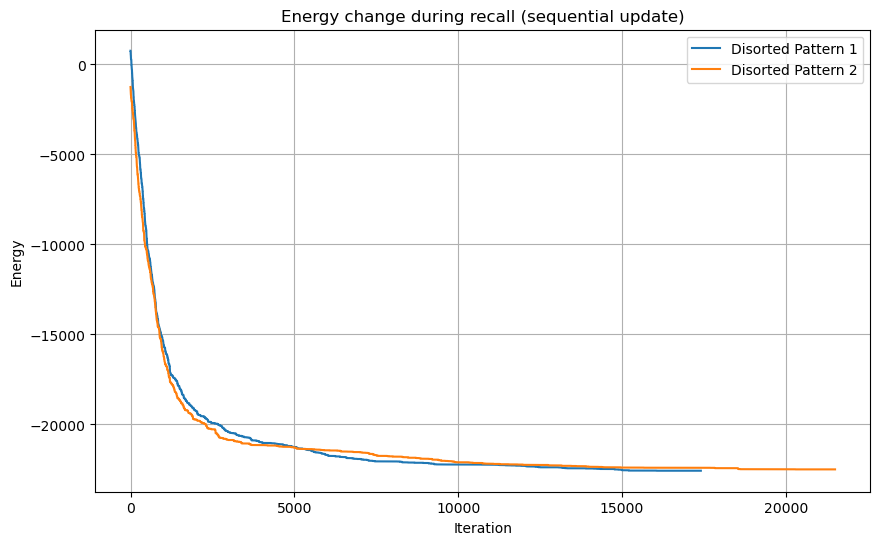

In [126]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net_energy(data=pic_data_3)

energy_list = []

for i, x in enumerate(pic_data_dist):
    recall,energy  = pic_net.recall_seq(x)
    energy_list.append(energy)


print(energy_list)

plt.figure(figsize=(10,6))

for i, energy_history in enumerate(energy_list):
    plt.plot(energy_history, label=f'Disorted Pattern {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy change during recall (sequential update)')
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Distortion Resistance

In [166]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp):
        recall_prev = np.copy(dp)
        recall = self.hop_sign(np.matmul(np.copy(dp), self.W))
        while not np.array_equal(recall, recall_prev):
            recall_prev = np.copy(recall)
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

In [167]:
def pic_noise(pic_data,noise_percentage):

    noisy_pic = np.copy(pic_data)
    n_pixels = noisy_pic.shape[0]
    n_flips = int(n_pixels*noise_percentage)

    np.random.seed(42)

    noise_indices = np.random.choice(n_pixels,size=n_flips, replace=False)

    noisy_pic[noise_indices] *= -1

    return noisy_pic


In [168]:
def calc_noise_removal(original_pic_data, noisy_pic_data, recalled_pic_data):


    corrupted_pixels = (original_pic_data != noisy_pic_data)
    n_corrupted = np.sum(corrupted_pixels)

    if n_corrupted == 0.0:
        return 100.0
    
    #figure out which of the corrupted pixels of the recalled image are equal to the correct image (calculate percentage of noise removal)
    fixed_pixels = (recalled_pic_data[corrupted_pixels] == original_pic_data[corrupted_pixels])
    n_fixed = np.sum(fixed_pixels)

    noise_removal_percentage = (n_fixed / n_corrupted) * 100
    
    return noise_removal_percentage

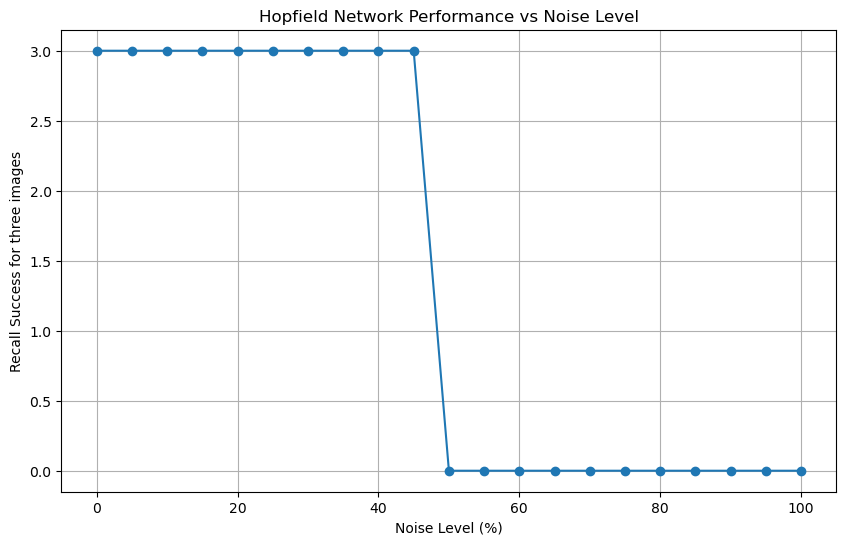

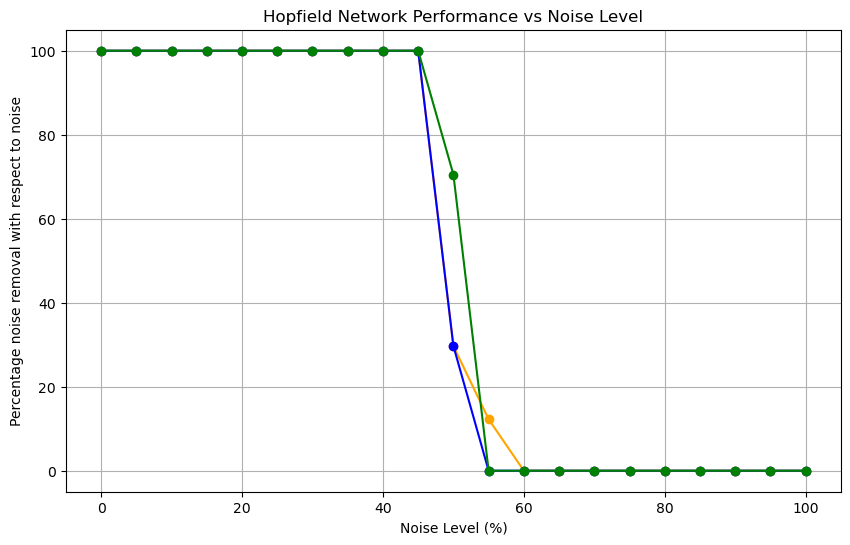

In [169]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 21
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
success_hist = []
noise_removal_hist = [[] for _ in range(pic_data_3.shape[0])]



for i, noise_level in enumerate(noise_levels):
    n_successful = 0
    for e in range(pic_data_3.shape[0]):

        noisy_pic = pic_noise(pic_data_3[e], noise_level)
        recalled = pic_net.recall_sync(noisy_pic)
        noise_removal_hist[e].append(calc_noise_removal(original_pic_data=pic_data_3[e],noisy_pic_data=noisy_pic,recalled_pic_data=recalled))

        if np.array_equal(pic_data_3[e], recalled):
            n_successful += 1
    success_hist.append(n_successful)



plt.figure(figsize=(10, 6))
plt.plot(noise_levels * 100, success_hist, marker='o')
plt.xlabel('Noise Level (%)')
plt.ylabel('Recall Success for three images')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()




plt.figure(figsize=(10, 6))
plt.plot(noise_levels*100, noise_removal_hist[0], marker='o' ,color='orange', label='Image 1')
plt.plot(noise_levels*100, noise_removal_hist[1], marker='o' ,color='blue' , label='Image 2')
plt.plot(noise_levels*100, noise_removal_hist[2], marker='o' ,color='green', label='Image 3')
plt.xlabel('Noise Level (%)')
plt.ylabel('Percentage noise removal with respect to noise')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()


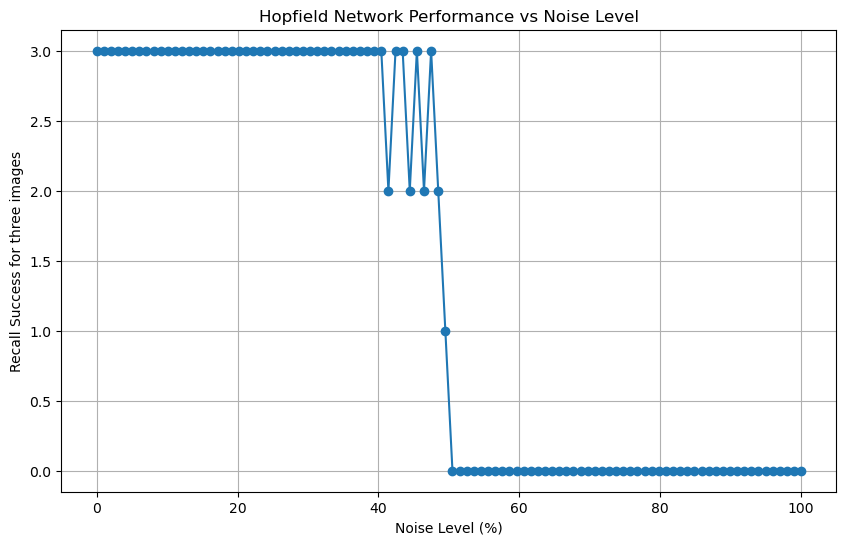

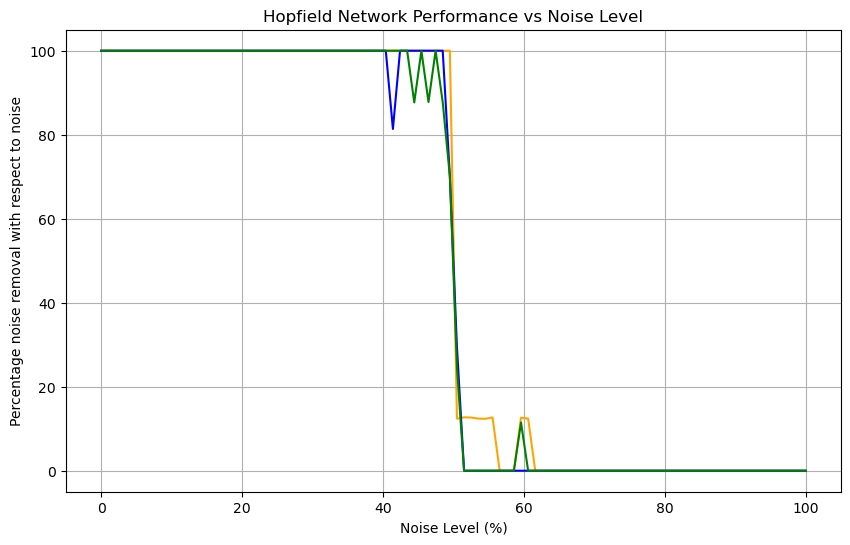

In [170]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 100
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
success_hist = []
noise_removal_hist = [[] for _ in range(pic_data_3.shape[0])]



for i, noise_level in enumerate(noise_levels):
    n_successful = 0
    for e in range(pic_data_3.shape[0]):

        noisy_pic = pic_noise(pic_data_3[e], noise_level)
        recalled = pic_net.recall_sync(noisy_pic)
        noise_removal_hist[e].append(calc_noise_removal(original_pic_data=pic_data_3[e],noisy_pic_data=noisy_pic,recalled_pic_data=recalled))

        if np.array_equal(pic_data_3[e], recalled):
            n_successful += 1
    success_hist.append(n_successful)



plt.figure(figsize=(10, 6))
plt.plot(noise_levels * 100, success_hist, marker='o')
plt.xlabel('Noise Level (%)')
plt.ylabel('Recall Success for three images')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()




plt.figure(figsize=(10, 6))
plt.plot(noise_levels*100, noise_removal_hist[0],color='orange', label='Image 1')
plt.plot(noise_levels*100, noise_removal_hist[1],color='blue' , label='Image 2')
plt.plot(noise_levels*100, noise_removal_hist[2],color='green', label='Image 3')
plt.xlabel('Noise Level (%)')
plt.ylabel('Percentage noise removal with respect to noise')
plt.title('Hopfield Network Performance vs Noise Level')
plt.grid(True)
plt.show()



#### Investigate different number of recall (so far only stopped when network converged)

In [180]:
class Hopfield_net():
    def __init__(self, data, scale=False):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.hebian_learn()

    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i], self.data[i])
        if self.scale:
            self.W /= self.data.shape[0]

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp, n_iterations):
        recall = np.copy(dp)
        for _ in range(n_iterations):
            recall = self.hop_sign(np.matmul(recall, self.W))
        return recall.astype(int)

    def recall_seq(self, dp, random=False):
        order = np.arange(dp.shape[0])
        if random:
            np.random.shuffle(order)
        recall_prev = np.copy(dp)
        recall = self.seq_update(dp, order)
        while not np.array_equal(recall, recall_prev):
            if random:
                np.random.shuffle(order)
            recall_prev = np.copy(recall)
            recall = self.seq_update(recall, order)
        return recall.astype(int)

    # Helper func to sequential update - makes one pass of sequential updates for all points
    def seq_update(self, recall, order):
        ret = np.copy(recall)
        for i in range(order.shape[0]):
            ret[order[i]] = self.hop_sign(np.matmul(self.W[order[i]], ret.transpose()))
        return ret

Testing with 1 iterations...
Testing with 2 iterations...
Testing with 3 iterations...
Testing with 4 iterations...
Testing with 5 iterations...


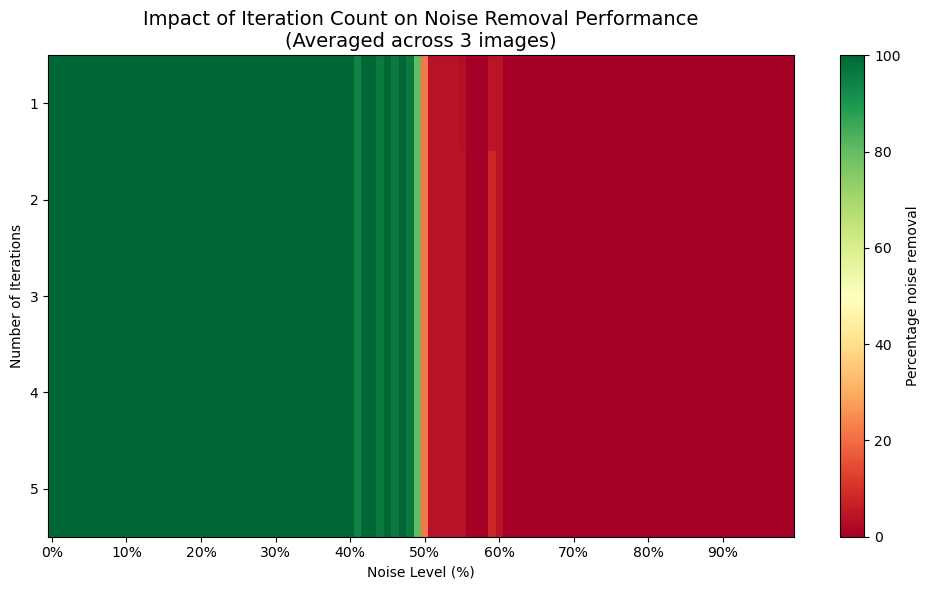

In [183]:
pic_data_3 = pic_data[:3]
pic_net = Hopfield_net(data=pic_data_3)
n = 100
noise_levels = np.linspace(0, 1.0, n)  # 0%, 5%, 10%, ..., 100%
n_iterations = [1,2,3,4,5]

heatmap_data = np.zeros((len(n_iterations),n))


for iter_idx, iterations in enumerate(n_iterations):
    print(f"Testing with {iterations} iterations...")
    
    for noise_idx, noise_level in enumerate(noise_levels):
        noise_removal_for_images = []
        
        for img_idx in range(pic_data_3.shape[0]):
            noisy_pic = pic_noise(pic_data_3[img_idx], noise_level)
            recalled = pic_net.recall_sync(noisy_pic, n_iterations=iterations)
            
            noise_removal = calc_noise_removal(
                original_pic_data=pic_data_3[img_idx],
                noisy_pic_data=noisy_pic,
                recalled_pic_data=recalled
            )
            noise_removal_for_images.append(noise_removal)
        
        heatmap_data[iter_idx, noise_idx] = np.mean(noise_removal_for_images)

plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
plt.xticks(np.arange(0, n, step=10), [f'{int(noise_levels[i]*100)}%' for i in range(0, n, 10)])
plt.yticks(np.arange(len(n_iterations)), n_iterations)
plt.colorbar(label='Percentage noise removal')
plt.xlabel('Noise Level (%)')
plt.ylabel('Number of Iterations')
plt.title('Impact of Iteration Count on Noise Removal Performance\n(Averaged across 3 images)', fontsize=14)
plt.tight_layout()
plt.show()


### 3.5 Capacity
Ivan 2025-10-04: I make the assumption that "moderately distorted patterns" correspond to 10% of patterns being distorted

In [36]:
# Ivan 2025-10-04: Based on the Hopfield net class in 3.4 (cell 1870 under "Investigate different number of recall (so far only stopped when network converged)")"
# Modifying it as follows:
# 1. Added exclude_self_connection flag
# 2. Added fucntiuon to update W, so Hopfiel network can be reused, instead of starting from scratch all the time
# 3. Addeed sparse functions for assignemtn 3.6 
class Hopfield_net():
    def __init__(self, data, scale=False, exclude_self_connection=False, rho=0):
        self.data = data
        self.W = np.zeros((data.shape[1], data.shape[1]))
        self.scale = scale
        self.exclude_self_connection = exclude_self_connection # NEWLY ADDED VARIABLE
        self.rho = rho # NEWLY ADDED VARIABLE (Assignment 3.6)
        self.hebian_learn()
        
        # For the last 2 questions of assignment 3.5 (checking effects of excluding self connection)
        if self.exclude_self_connection:
            np.fill_diagonal(self.W, 0) # remove self connections

    # Added rho for assignment 3.6 Sparse Patterns
    def hebian_learn(self):
        for i in range(self.data.shape[0]):
            self.W += np.outer(self.data[i] - self.rho, self.data[i] - self.rho)
        if self.scale:
            self.W /= self.data.shape[0]
    # NEWLY ADDED FUNCTION updated_weights
    # This logic is implemented to reduce computational time
    def update_weights(self, new_data):
        self.W += np.outer(new_data - self.rho, new_data - self.rho)

        # For the last 2 questions of assignment 3.5 (checking effects of excluding self connection)
        if self.exclude_self_connection:
            np.fill_diagonal(self.W, 0) # remove self connections

    # Numpy sign sets sign of 0 to 0 - change it to 1
    def hop_sign(self, dp):
        temp = np.sign(dp)
        return np.where(temp == 0, 1, temp)
    
    def recall_sync(self, dp, n_iterations, include_bias=False, theta=0):
        recall = np.copy(dp)
        for _ in range(n_iterations):
            if include_bias:
                sign = np.sign(np.matmul(recall, self.W) - theta)
                recall = 0.5 + (0.5 * sign)
            else:
                recall = self.hop_sign(np.matmul(recall, self.W))

        return recall.astype(int)



In [37]:
# Copy of the first assignment (made into function so we can get all pictures)
def get_pictures():
    file_path_pic_data = 'datasets/pict.dat'

    num_pics = 11
    num_attrs = 1024

    # Open file and read in the array from string to int
    raw_data = []
    with open(file_path_pic_data, 'r') as file:
        for line in file:
            raw_data = list(map(int, line.split(',')))
            # It should only be a single line but just in case
            break
    pic_data = np.array(raw_data).reshape(num_pics, num_attrs)

    # Sanity check that we did the reshaping right
    for i in range(num_pics):
        for j in range(num_attrs):
            if raw_data[num_attrs*i + j] != pic_data[i, j]:
                print("Error, reshape incorrect!")

    return pic_data

# Sanity check
pic_data = get_pictures()
print(pic_data.shape) # Should bee 11 pictures, with 1024 pixel

(11, 1024)


In [38]:
# Copy of pic noiser from last assignment
def pic_noise(pic_data,noise_percentage):
    noisy_pic = np.copy(pic_data)
    n_pixels = noisy_pic.shape[0]
    n_flips = int(n_pixels*noise_percentage) # Number of noise pixels to introduce

    np.random.seed(42)

    noise_indices = np.random.choice(n_pixels,size=n_flips, replace=False) # Choose random indices
    noisy_pic[noise_indices] *= -1 # Insert the noise in the randomly chosen indices

    return noisy_pic

In [39]:
# Sanoty check (SKIP)
pics_distorted = []
for pic in pic_data[:3]:
        pic_distorted = pic_noise(pic, 0) # 10% noise (moderate noise)
        pics_distorted.append(pic_distorted)
    
pics_distorted = np.array(pics_distorted)
print(pic_data[:3])
print(pics_distorted)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 1  1  1 ...  1  1  1]]
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [ 1  1  1 ...  1  1  1]]


In [40]:
# Function that calculates accuracy of recall when increasing the patterns used to train the network
def check_capacity(
        patterns, 
        noise_inclusion, 
        recall_iterations=1000, 
        retrain_hopfield_network=True, 
        exclude_self_connection=False, 
        plot_results=True,
        sparse=False,
        rho=0,
        theta=0
    ):
    number_of_patterns_list = list(range(1, patterns.shape[0] + 1)) # Create a list of number of patterns (to loop through)
    print(f"Number of patterns: {len(number_of_patterns_list)}")
    recall_accuracy = []

    hop_model = None
    
    # Train hopfield network on increasing number of patterns 
    for number_of_patterns in number_of_patterns_list:
        correct_recalls = 0
        input_patterns = patterns[:number_of_patterns]
        
        # Train network on first X patterns
        # This logic is implemented to reduce computational time
        if hop_model == None or retrain_hopfield_network:
            hop_model = Hopfield_net(data=input_patterns, scale=False, exclude_self_connection=exclude_self_connection, rho=rho)
        else:
            hop_model.update_weights(new_data=input_patterns[-1])
        
        # Distort first X pictures and check recall
        for pattern in input_patterns:
            pattern_distorted = pic_noise(pattern, noise_inclusion) # pic_noise also work for random numbers
        
            # Recall distorted picture
            if sparse:
                recalled = hop_model.recall_sync(pattern_distorted, n_iterations=recall_iterations, include_bias=True, theta=theta)
            else:
                recalled = hop_model.recall_sync(pattern_distorted, n_iterations=recall_iterations, include_bias=False)
            resulting_recall = np.array_equal(pattern, recalled)
            if resulting_recall:
                correct_recalls += 1

        # Calculate accuracy
        accuracy = correct_recalls / number_of_patterns
        recall_accuracy.append(accuracy)

    if plot_results:

        # Making x-axis a bit nicer
        if len(number_of_patterns_list) >= 50 and len(number_of_patterns_list) <= 200:
            x_ticks = list(range(0, patterns.shape[0], 5))
            
        elif len(number_of_patterns_list) > 200 and len(number_of_patterns_list) <= 1000:
            x_ticks = list(range(0, patterns.shape[0], 25))
        else:
            x_ticks = number_of_patterns_list
        print(f"Number of ticks on x_axis {x_ticks}")
        print(f"Sample count accuracy: {recall_accuracy}")
        
        # Plot accuacy
        plt.figure(figsize=(10, 6))
        plt.plot(number_of_patterns_list, recall_accuracy, marker='o')
        plt.xlabel('Number of stored patterns')
        plt.ylabel('Recall Success rate')
        plt.title(f'Hopfield Network Performance with {100 * noise_inclusion}% noise')
        plt.xticks(x_ticks)
        plt.grid(True)
        plt.show()
    
    return recall_accuracy


#### Q1 code: Test the picture data

Number of patterns: 11
Number of ticks on x_axis [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Sample count accuracy: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091]


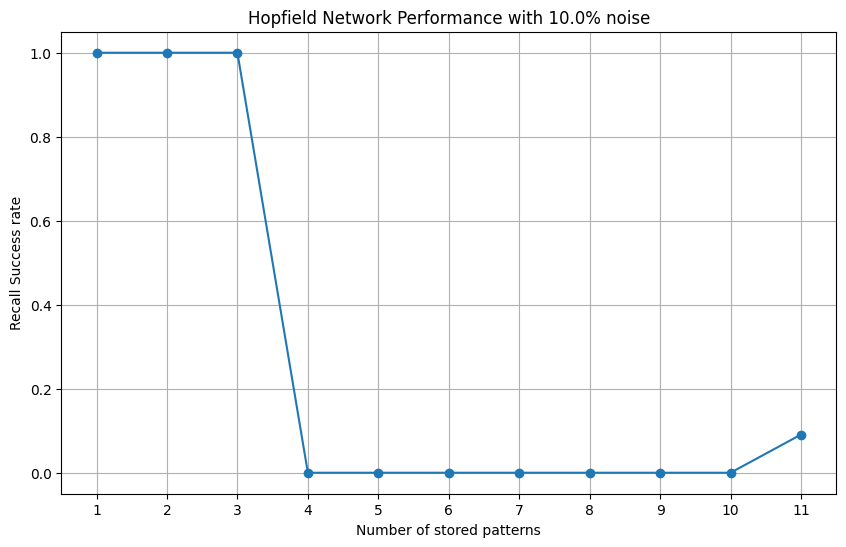

In [7]:
recall_accuracy = check_capacity(pic_data, noise_inclusion=0.1) # 10% noise

#### Q1 Answer: The drop in performance was abrupt, accuracy become 0 directly after 3 pictures

#### Q2 code: Repeat with a few random patterns instead of pictures

In [43]:
# Function to generate random patterns
def generate_random_patterns(number_of_patterns, length, bias=False, binary_pattern=False, p=[0.7, 0.3]):
    if bias:
        patterns = np.random.choice([1, -1], size=(number_of_patterns, length), p=p)
    else: 
        patterns = np.random.choice([1, -1], size=(number_of_patterns, length)) # creates patterns with 1 and -1 values

    # For assignment 3.6
    if binary_pattern:
        patterns = np.random.choice([1, 0], size=(number_of_patterns, length), p=p)

    return patterns

# Sanity check
print(generate_random_patterns(3, 5))
print(generate_random_patterns(3, 5, bias=True))
test = generate_random_patterns(5, 6, binary_pattern=True, p=[0.1, 0.9])
print(test)
print(np.sum(test))

[[-1  1  1  1 -1]
 [ 1 -1 -1 -1  1]
 [ 1  1  1 -1 -1]]
[[ 1  1 -1  1  1]
 [ 1  1  1  1  1]
 [-1 -1  1  1  1]]
[[1 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
4


Number of patterns: 20
Number of ticks on x_axis [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


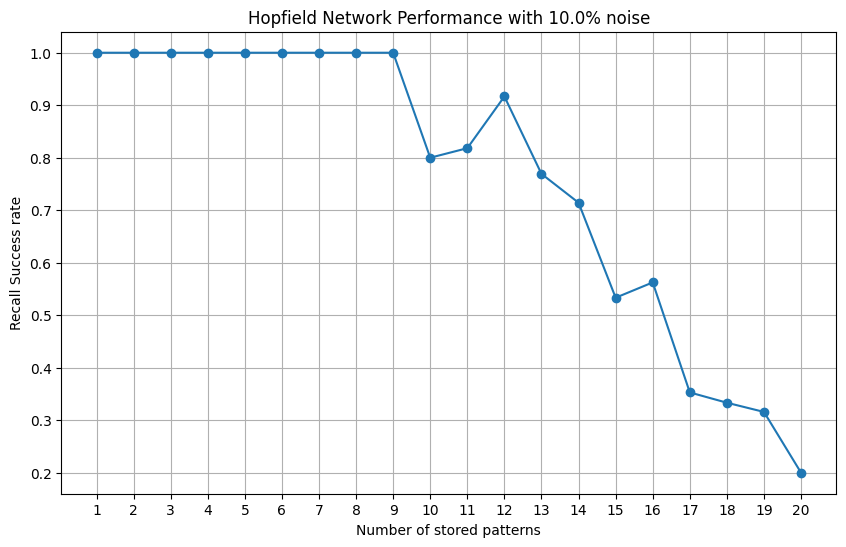

In [10]:
random_patterns = generate_random_patterns(20, 70)
recall_accuracy = check_capacity(random_patterns, noise_inclusion=0.1) # 10% noise

#### Q2 Answer: We can store more patterns using 20 patterns, each with 70 bits

#### Q3 Answer: It is apparant that we can store more patterns using the random patterns, compared to the pictures
This seems a bit strange, considering we have for picture, the capacity should be around 0.138 * 1024 = 141 patterns, but we can have a maximum of 3 patterns, after that we gat 0% accuracy in recall.

For random patterns however, we can store 11 patterns, which is > 0.138 * 70 = 9.66.

The difference can be explained by the pictures being more structured than the random generate numbers, and are more likely to interfere eachother during training, creating more erroneoues attractors. 

#### Q4 Code:  What happens with the number of stable patters as more are learned (create 300 random patterns and train >= 100-unit network)

In [ ]:
# Ivan 2025-10-05 - Changed so plotting of stable and noisy patterns is done together in one graph in Q5 code section
random_patterns = generate_random_patterns(300, 100)
recall_accuracy_stable = check_capacity(random_patterns, noise_inclusion=0, recall_iterations=1, retrain_hopfield_network=False, plot_results=False) # 0% noise

Number of patterns: 300


#### Q4 Answer: Initially as more stable paterns are learned, the success rates take a rather sharp dive. However, a more patterns are leeaerned, the success rate increases, which could be the result of more random patterns being similar, creating more similar attractors (i.e. we get false positives)

#### Q5 Code: What happens to convergence to the patterns from a noisy version?

In [13]:
random_patterns = generate_random_patterns(300, 100)
recall_accuracy_noisy = check_capacity(random_patterns, noise_inclusion=0.05, recall_iterations=100, retrain_hopfield_network=False, plot_results=False) # 5% noise

Number of patterns: 300


In [22]:
# Plot stable and noisy patterns
# Making x-axis a bit nicer
def plot_data(patterns, recall_accuracy_stable, recall_accuracy_noisy, title):
    number_of_patterns_list = list(range(1, patterns.shape[0] + 1)) # Create a list of number of patterns (to loop through)
    if len(number_of_patterns_list) >= 50 and len(number_of_patterns_list) <= 200:
        x_ticks = list(range(0, patterns.shape[0], 5))
        
    elif len(number_of_patterns_list) > 200 and len(number_of_patterns_list) <= 1000:
        x_ticks = list(range(0, patterns.shape[0], 25))
    else:
        x_ticks = number_of_patterns_list
    print(f"Number of ticks on x_axis {x_ticks}")
    print(f"Sample count accuracy: {recall_accuracy}")

    # Plot accuacy
    plt.figure(figsize=(10, 6))
    plt.plot(number_of_patterns_list, recall_accuracy_stable, marker='o', color='blue', label='Stable')
    plt.plot(number_of_patterns_list, recall_accuracy_noisy, marker='o', color='red', label='Noisy 5%')
    plt.xlabel('Number of stored patterns')
    plt.ylabel('Recall Success rate')
    plt.title(title)
    plt.xticks(x_ticks)
    plt.grid(True)
    plt.legend()
    plt.show()



Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


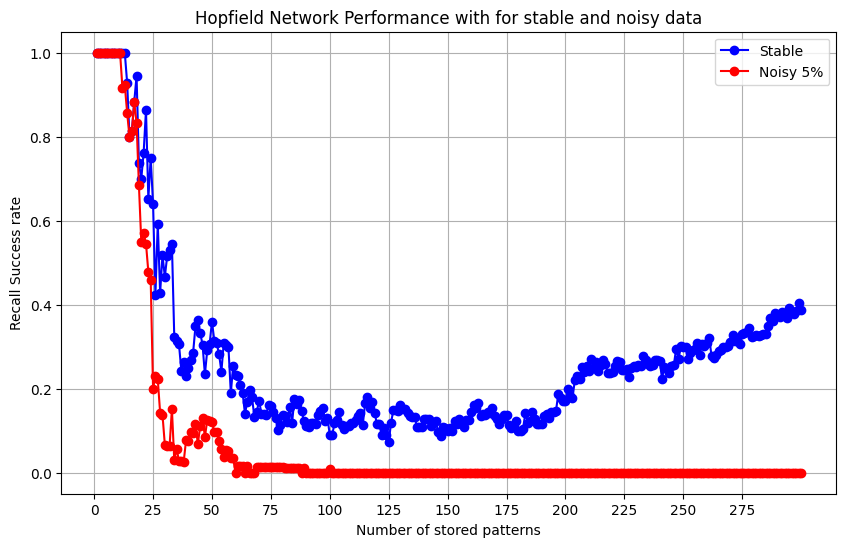

In [23]:
plot_data(
    patterns=random_patterns,
    recall_accuracy_stable=recall_accuracy_stable,
    recall_accuracy_noisy=recall_accuracy_noisy,
    title='Hopfield Network Performance with for stable and noisy data',
    )

#### Q5 Answer: Introducing noise to the random data makes the accuracy drop sharply. By adding a large amount of noisy patterns, the creation of spuriouis attractors is increased, whichh the neteowork woudl converge to. This makes sense as the capacity of the hopfield network is in this case 0.138 * 100 = 14 patterns.

#### Q6 Code: What is the maximum number of retrievable patterns for network without self-connections?

In [ ]:
# Pure data (nno noise)
random_patterns = generate_random_patterns(300, 100)
recall_accuracy_stable = check_capacity(random_patterns, noise_inclusion=0, recall_iterations=1, retrain_hopfield_network=False, exclude_self_connection=True, plot_results=False) # 0% noise

Number of patterns: 300


In [27]:
# Noisy data
random_patterns = generate_random_patterns(300, 100)
recall_accuracy_noisy = check_capacity(random_patterns, noise_inclusion=0.05, recall_iterations=100, retrain_hopfield_network=False, exclude_self_connection=True, plot_results=False) # 5% noise

Number of patterns: 300


Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


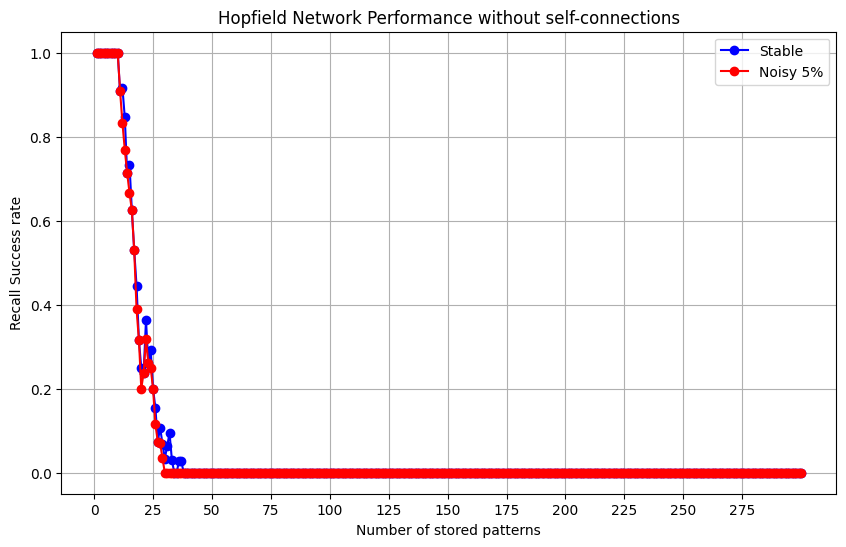

In [28]:
plot_data(
    patterns=random_patterns,
    recall_accuracy_stable=recall_accuracy_stable,
    recall_accuracy_noisy=recall_accuracy_noisy,
    title='Hopfield Network Performance without self-connections',
    )

#### Q6 Answer: When self-connection is removed, both noisy and not noisy patterns exhibit the same patterns; afteer approximately 10 learned patterns, the network becomes unstable and has a rather sharp drop in accuracy, until around 27-30 patterns, from which the accuracy is constantly 0

#### Q7 Code: Introduce bias to 1

In [29]:
# Pure data (nno noise)
random_patterns = generate_random_patterns(300, 100, bias=True)
recall_accuracy_stable = check_capacity(random_patterns, noise_inclusion=0, recall_iterations=1, retrain_hopfield_network=False, exclude_self_connection=True, plot_results=False) # 0% noise

Number of patterns: 300


In [30]:
# Noisy data
random_patterns = generate_random_patterns(300, 100, bias=True)
recall_accuracy_noisy = check_capacity(random_patterns, noise_inclusion=0.05, recall_iterations=100, retrain_hopfield_network=False, exclude_self_connection=True, plot_results=False) # 5% noise

Number of patterns: 300


Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


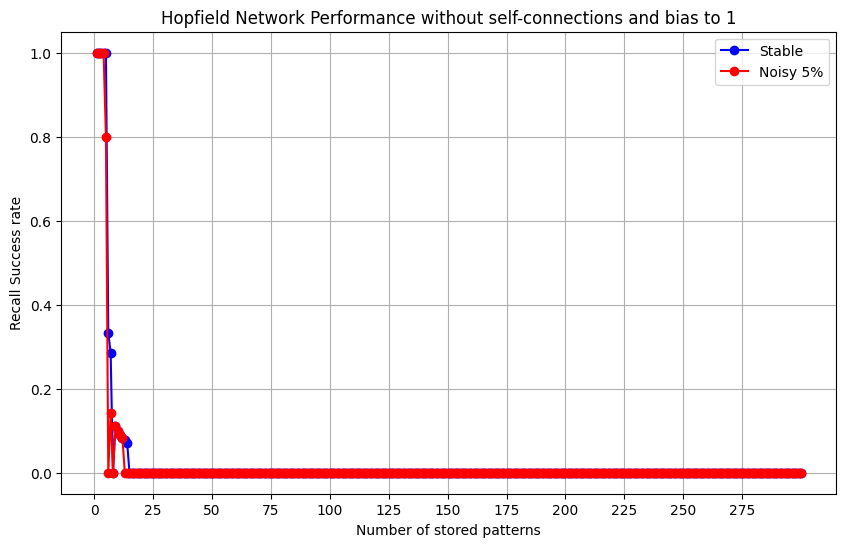

In [31]:
plot_data(
    patterns=random_patterns,
    recall_accuracy_stable=recall_accuracy_stable,
    recall_accuracy_noisy=recall_accuracy_noisy,
    title='Hopfield Network Performance without self-connections and bias to 1',
    )

#### Q7 Answer: Introducing bias to the patterns data reduces the capacoty of the network. This is similar to the accuracy of the picture patterns, and is caused by reduced randomness

### 3.6 Sparse patterns

#### Q1 Code: Sparse data with rho = 0.1

In [52]:
# Pure data (no noise). Generate binary patterns with 10% activity (10% 1s)
random_patterns = generate_random_patterns(300, 100, bias=True, binary_pattern=True, p=[0.1, 0.9])
# Calculate the activity (should be 10%, but as we randomly generate the patterns with probability 0.1 for 1s and 0.9 for 0s, it wont be entirely true)
rho = np.sum(random_patterns) / (300*100)
thetas = [0, 0.5, 1, 5, 10, 20]
recalls_accuracy = []

# Test different thetas
for theta in thetas:
    recall_accuracy_stable = check_capacity(
        random_patterns,
        noise_inclusion=0,
        recall_iterations=1,
        retrain_hopfield_network=False,
        exclude_self_connection=True,
        plot_results=False,
        sparse=True,
        rho=rho,
        theta=theta
        )
    
    recalls_accuracy.append(recall_accuracy_stable)



Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300


In [62]:
import collections

for i, theta in enumerate(thetas):
    counter = collections.Counter(recalls_accuracy[i])
    print(f"Capacity with theta = {theta} -> {counter.get(1)}")


Capacity with theta = 0 -> 1
Capacity with theta = 0.5 -> 1
Capacity with theta = 1 -> 1
Capacity with theta = 5 -> 10
Capacity with theta = 10 -> None
Capacity with theta = 20 -> None


Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


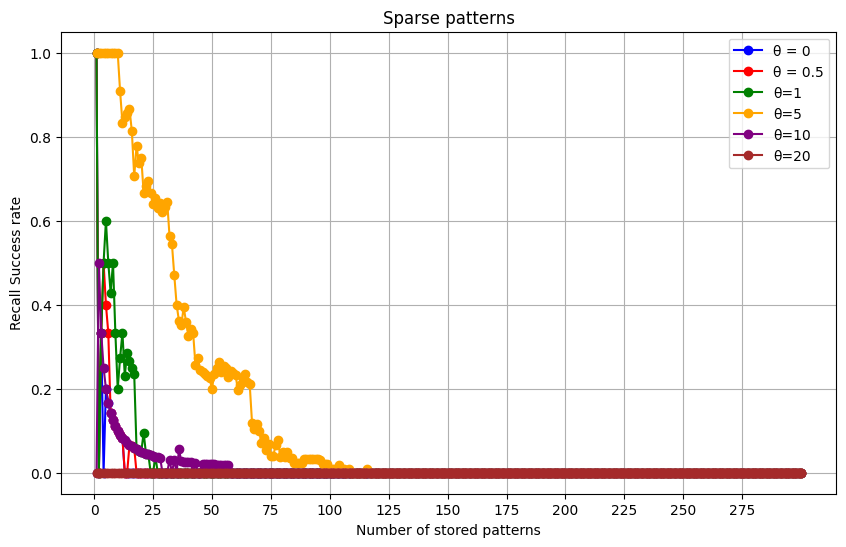

In [ ]:
# Plot the patterns
number_of_patterns_list = list(range(1, random_patterns.shape[0] + 1)) # Create a list of number of patterns (to loop through)

if len(number_of_patterns_list) >= 50 and len(number_of_patterns_list) <= 200:
    x_ticks = list(range(0, random_patterns.shape[0], 5))
    
elif len(number_of_patterns_list) > 200 and len(number_of_patterns_list) <= 1000:
    x_ticks = list(range(0, random_patterns.shape[0], 25))
else:
    x_ticks = number_of_patterns_list
print(f"Number of ticks on x_axis {x_ticks}")
print(f"Sample count accuracy: {recall_accuracy}")

# Plot accuacy
plt.figure(figsize=(10, 6))
plt.plot(number_of_patterns_list, recalls_accuracy[0], marker='o', color='blue', label='\u03B8 = 0')
plt.plot(number_of_patterns_list, recalls_accuracy[1], marker='o', color='red', label='\u03B8 = 0.5')
plt.plot(number_of_patterns_list, recalls_accuracy[2], marker='o', color='green', label='\u03B8=1')
plt.plot(number_of_patterns_list, recalls_accuracy[3], marker='o', color='orange', label='\u03B8=5')
plt.plot(number_of_patterns_list, recalls_accuracy[4], marker='o', color='purple', label='\u03B8=10')
plt.plot(number_of_patterns_list, recalls_accuracy[5], marker='o', color='brown', label='\u03B8=20')
plt.xlabel('Number of stored patterns')
plt.ylabel('Recall Success rate')
plt.title("Sparse patterns")
plt.xticks(x_ticks)
plt.grid(True)
plt.legend()
plt.show()


#### Q1 Answer: For low thetas the capacity is only one, but when theta is 5 teh capacioty becomes 10. However, for larger thetas there is n o more capacity. Why? 

#### Q2 Code: try for sparser patterns

##### rho = 0.05

In [63]:
# Pure data (no noise). Generate binary patterns with 5% activity (5% 1s)
random_patterns = generate_random_patterns(300, 100, bias=True, binary_pattern=True, p=[0.05, 0.95])
# Calculate the activity
rho = np.sum(random_patterns) / (300*100)
thetas = [0, 0.5, 1, 5, 10, 20]
recalls_accuracy = []

# Test different thetas
for theta in thetas:
    recall_accuracy_stable = check_capacity(
        random_patterns,
        noise_inclusion=0,
        recall_iterations=1,
        retrain_hopfield_network=False,
        exclude_self_connection=True,
        plot_results=False,
        sparse=True,
        rho=rho,
        theta=theta
        )
    
    recalls_accuracy.append(recall_accuracy_stable)

Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300


In [64]:
for i, theta in enumerate(thetas):
    counter = collections.Counter(recalls_accuracy[i])
    print(f"Capacity with theta = {theta} -> {counter.get(1)}")


Capacity with theta = 0 -> 1
Capacity with theta = 0.5 -> 1
Capacity with theta = 1 -> 3
Capacity with theta = 5 -> None
Capacity with theta = 10 -> None
Capacity with theta = 20 -> None


Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


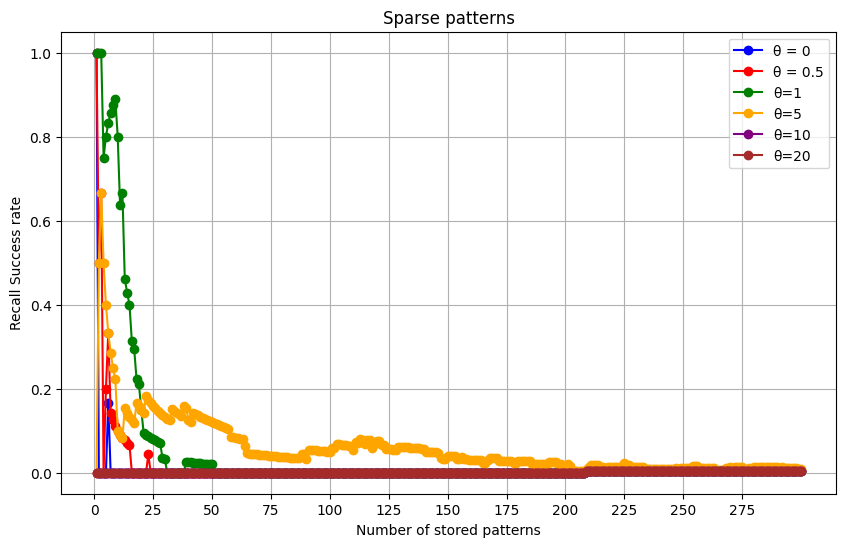

In [ ]:
# Plot the patterns
number_of_patterns_list = list(range(1, random_patterns.shape[0] + 1)) # Create a list of number of patterns (to loop through)

if len(number_of_patterns_list) >= 50 and len(number_of_patterns_list) <= 200:
    x_ticks = list(range(0, random_patterns.shape[0], 5))
    
elif len(number_of_patterns_list) > 200 and len(number_of_patterns_list) <= 1000:
    x_ticks = list(range(0, random_patterns.shape[0], 25))
else:
    x_ticks = number_of_patterns_list
print(f"Number of ticks on x_axis {x_ticks}")
print(f"Sample count accuracy: {recall_accuracy}")

# Plot accuacy
plt.figure(figsize=(10, 6))
plt.plot(number_of_patterns_list, recalls_accuracy[0], marker='o', color='blue', label='\u03B8 = 0')
plt.plot(number_of_patterns_list, recalls_accuracy[1], marker='o', color='red', label='\u03B8 = 0.5')
plt.plot(number_of_patterns_list, recalls_accuracy[2], marker='o', color='green', label='\u03B8 =1')
plt.plot(number_of_patterns_list, recalls_accuracy[3], marker='o', color='orange', label='\u03B8=5')
plt.plot(number_of_patterns_list, recalls_accuracy[4], marker='o', color='purple', label='\u03B8=10')
plt.plot(number_of_patterns_list, recalls_accuracy[5], marker='o', color='brown', label='\u03B8=20')
plt.xlabel('Number of stored patterns')
plt.ylabel('Recall Success rate')
plt.title("Sparse patterns")
plt.xticks(x_ticks)
plt.grid(True)
plt.legend()
plt.show()

##### rho = 0.01

In [66]:
# Pure data (no noise). Generate binary patterns with 1% activity (1% 1s)
random_patterns = generate_random_patterns(300, 100, bias=True, binary_pattern=True, p=[0.01, 0.99])
# Calculate the activity
rho = np.sum(random_patterns) / (300*100)
thetas = [0, 0.5, 1, 5, 10, 20]
recalls_accuracy = []

# Test different thetas
for theta in thetas:
    recall_accuracy_stable = check_capacity(
        random_patterns,
        noise_inclusion=0,
        recall_iterations=1,
        retrain_hopfield_network=False,
        exclude_self_connection=True,
        plot_results=False,
        sparse=True,
        rho=rho,
        theta=theta
        )
    
    recalls_accuracy.append(recall_accuracy_stable)

Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300
Number of patterns: 300


In [67]:
for i, theta in enumerate(thetas):
    counter = collections.Counter(recalls_accuracy[i])
    print(f"Capacity with theta = {theta} -> {counter.get(1)}")

Capacity with theta = 0 -> 1
Capacity with theta = 0.5 -> 1
Capacity with theta = 1 -> 1
Capacity with theta = 5 -> 1
Capacity with theta = 10 -> 1
Capacity with theta = 20 -> 1


Number of ticks on x_axis [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
Sample count accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8181818181818182, 0.9166666666666666, 0.7692307692307693, 0.7142857142857143, 0.5333333333333333, 0.5625, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.2]


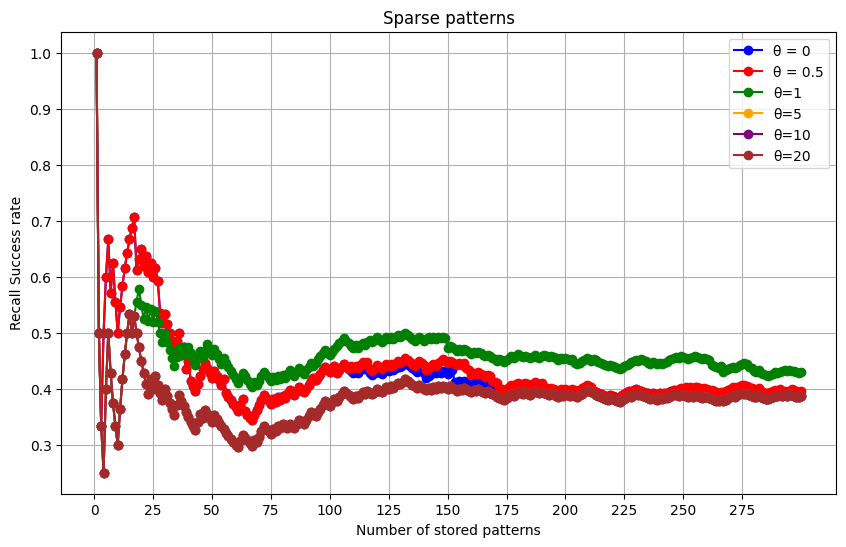

In [ ]:
# Plot the patterns
number_of_patterns_list = list(range(1, random_patterns.shape[0] + 1)) # Create a list of number of patterns (to loop through)

if len(number_of_patterns_list) >= 50 and len(number_of_patterns_list) <= 200:
    x_ticks = list(range(0, random_patterns.shape[0], 5))
    
elif len(number_of_patterns_list) > 200 and len(number_of_patterns_list) <= 1000:
    x_ticks = list(range(0, random_patterns.shape[0], 25))
else:
    x_ticks = number_of_patterns_list
print(f"Number of ticks on x_axis {x_ticks}")
print(f"Sample count accuracy: {recall_accuracy}")

# Plot accuacy
plt.figure(figsize=(10, 6))
plt.plot(number_of_patterns_list, recalls_accuracy[0], marker='o', color='blue', label='\u03B8 = 0')
plt.plot(number_of_patterns_list, recalls_accuracy[1], marker='o', color='red', label='\u03B8 = 0.5')
plt.plot(number_of_patterns_list, recalls_accuracy[2], marker='o', color='green', label='\u03B8=1')
plt.plot(number_of_patterns_list, recalls_accuracy[3], marker='o', color='orange', label='\u03B8=5')
plt.plot(number_of_patterns_list, recalls_accuracy[4], marker='o', color='purple', label='\u03B8=10')
plt.plot(number_of_patterns_list, recalls_accuracy[5], marker='o', color='brown', label='\u03B8=20')
plt.xlabel('Number of stored patterns')
plt.ylabel('Recall Success rate')
plt.title("Sparse patterns")
plt.xticks(x_ticks)
plt.grid(True)
plt.legend()
plt.show()